# Lesson 10: CNN
https://www.youtube.com/watch?v=LgFNRIFxuUo&list=PLlMkM4tgfjnJ3I-dbhO9JTw7gNty6o_2m&index=10

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [22]:
torch.manual_seed(1249583)

Define `Dataset`

In [23]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=10, shuffle=True)

In [24]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=1, shuffle=True)

In [50]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_test = []
y_pred = []

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            y_test.append(int(target))
            y_pred.append(int(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=[i for i in range(1, 10 + 1)], normalize=True,
                          title='Normalized confusion matrix')


# 1. Model

In [46]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1) # in_channel is 1. Because it has 1 color
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(320, 10)
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1) # flatten the tensor
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [47]:
model = Net()

# 2. Loss & Optimizer
criterion has been absorbed to the `train and test` functions already

In [48]:
optimizer = optim.SGD(model.parameters(), lr=0.001 , momentum=0.1)

# 3. Train


Test set: Average loss: 0.2050, Accuracy: 9377/10000 (94%)

[[ 973    0    1    1    0    2    1    1    1    0]
 [   0 1112    4    3    0    3    1    0   12    0]
 [  14    2  965    8    8    0    2   14   13    6]
 [   2    0   10  961    0    9    0    4    9   15]
 [   1    0    3    1  913    0    7    0    4   53]
 [  15    3    4   34    3  797    8    2   15   11]
 [  20    3    2    2   12   16  902    0    1    0]
 [   4   11   31    7    1    0    0  902    4   68]
 [  10    2    6   21    6    6    3    4  895   21]
 [  12    6    5    8    9    4    0    5    3  957]]


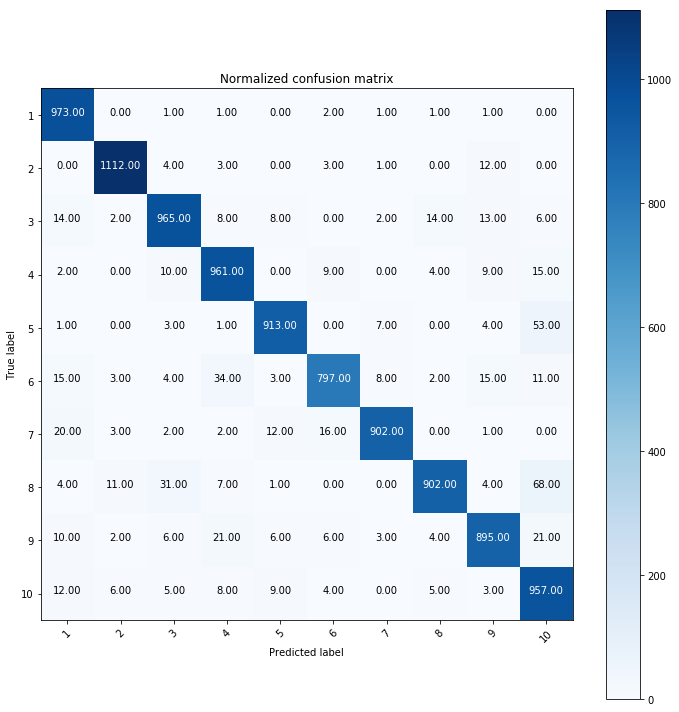

In [51]:
for epoch in range(1, 1 + 1):
    train(model, 'cpu', train_loader, optimizer, epoch)
    test(model, 'cpu', test_loader)